In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import loompy
import cytograph as cg 
import pandas as pd
from sklearn.neighbors import kneighbors_graph
from sklearn.manifold import TSNE

In [3]:
def loompy2data(filename):
    ds = loompy.connect(filename)
    return pd.DataFrame(data=ds[:,:], columns=ds.col_attrs['CellID'], index=ds.row_attrs['Gene']).astype(int)

def loompy2annot(filename):
    ds = loompy.connect(filename)
    return pd.DataFrame( ds.col_attrs, index=ds.col_attrs['CellID'] ).T

def loompy2data_annot(filename):
    ds = loompy.connect(filename)
    return (pd.DataFrame(data=ds[:,:],
                        columns=ds.col_attrs['CellID'],
                        index=ds.row_attrs['Gene']).astype(int),
            pd.DataFrame( ds.col_attrs,
                         index=ds.col_attrs['CellID'] ).T )

In [4]:
fname = "/data2/loom_files/development/combined/P7_cortex.loom"

In [5]:
ds = loompy.connect(fname)
sum(ds.col_attrs["Low_expression_flag"])

2017-01-14 14:40:40,124 - INFO - Connecting to: /data2/loom_files/development/combined/P7_cortex.loom


0

In [71]:
ds[0,1]

0.0

In [6]:
df, annotations = loompy2data_annot(fname)

2017-01-14 14:40:41,171 - INFO - Connecting to: /data2/loom_files/development/combined/P7_cortex.loom


In [7]:
low_complexity_flag = annotations.ix["Low_complexity_flag"]
low_expression_flag = annotations.ix["Low_expression_flag"]

In [8]:
included_flag = ~(low_expression_flag | low_complexity_flag)

In [9]:
df = df.ix[:,included_flag]
annotations = annotations.ix[:,included_flag]

In [10]:
sum(included_flag), len(included_flag)

(5735, 6063)

In [11]:
total_gene = np.sum(df.values,1)

In [12]:
total_expressing = (df.values>0).sum(1)

In [13]:
df = df.ix[(total_gene>8)&(total_expressing>4),:]

In [14]:
# Fitting CVvsMean noise model
mu = df.values.mean(1)
sigma = df.values.std(1, ddof=1)
cv = sigma/mu
score, mu_linspace, cv_fit , fitted_fun = cg.bi_pca.fit_CV(mu,cv, 'SVR', svr_gamma=0.005)

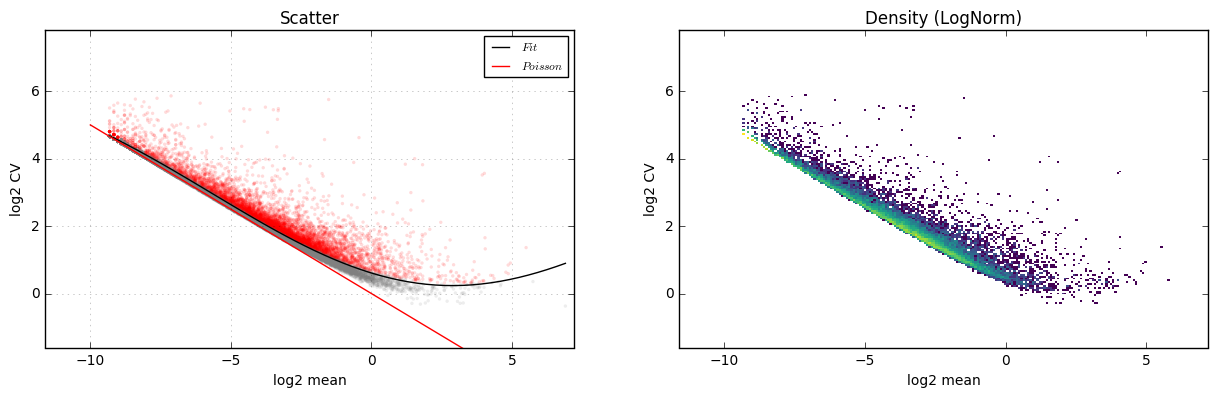

In [15]:
#Plotting
from matplotlib.colors import LogNorm
thrs = 5000
figure(figsize=(15,15))

subplot(121)

mu_sorted = mu[argsort(score)[::-1]]
cv_sorted = cv[argsort(score)[::-1]]
scatter(log2(mu_sorted[thrs:]),log2(cv_sorted[thrs:]), marker='o', edgecolor ='none',alpha=0.14, s=6, c='gray')
scatter(log2(mu_sorted[:thrs]),log2(cv_sorted[:thrs]), marker='o', edgecolor ='none',alpha=0.14, s=6, c='r')
plot(mu_linspace, cv_fit,'-k', linewidth=1, label='$Fit$')
plot(linspace(-10,7), -0.5*linspace(-10,7), '-r', label='$Poisson$')
#Adjusting plot
ylabel('log2 CV')
xlabel('log2 mean')
grid(alpha=0.3)
xlim(-11.6,7.2)
ylim(-1.6,7.8)
legend(loc=1, fontsize='small')
title('Scatter')
gca().set_aspect(1.2)

subplot(122)
hist2d(log2(mu_sorted),log2(cv_sorted), bins=[200,170],
       range=[[-9.6,6.7],[-1.6,7.8]], norm=LogNorm(),cmap=cm.viridis);
xlim(-11.6,7.2)
ylim(-1.6,7.8)
#legend(loc=1, fontsize='small')
#Adjusting plot
ylabel('log2 CV')
xlabel('log2 mean')
title('Density (LogNorm)')
gca().set_aspect(1.2)

In [16]:
feature_selected = df.index[argsort(score)[::-1]][:5000]

In [17]:
data = df.ix[feature_selected,:].values

In [18]:
data_tmp = np.log2(data + 1)
data_tmp -= data_tmp.mean(1)[:, None]

In [19]:
from sklearn.decomposition import FactorAnalysis
fca = FactorAnalysis(n_components=50)
fcs = fca.fit_transform( data_tmp.T ).T

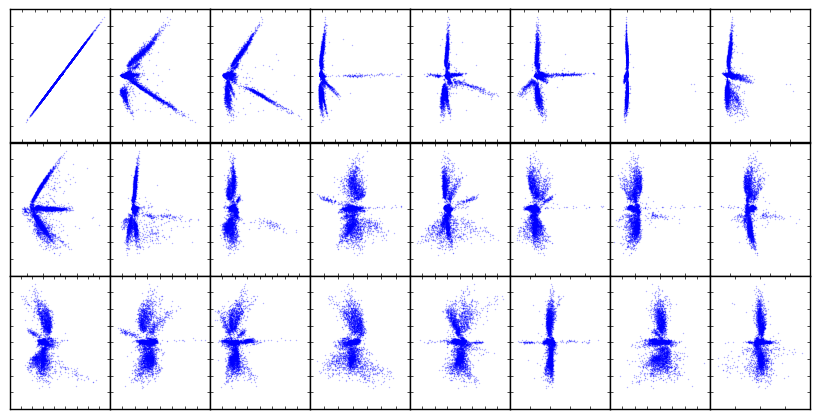

In [20]:
figure( figsize=(8,4))
#couple_pcs = list(combinations(range(6),2))
ccc = "b"#0.3*cm.prism(labels/max(labels)) + 0.7*cm.spectral(labels/max(labels))
for i, a in enumerate(range(24)):
    ax = subplot(3,8,i+1)
    scatter(  fcs[i,:],fcs[0,:],s=1, c=ccc, lw=0, alpha=0.3)
    ax.tick_params(labelbottom=False, labeltop=False, labelleft=False, labelright=False, size=2)
    
tight_layout(pad=0.01, h_pad=0.01, w_pad=0.01)

In [35]:
pcs.T.shape

(5735, 50)

In [21]:
# KNN graph generation and clustering
knn = kneighbors_graph(fcs.T, mode='distance', n_neighbors=30, n_jobs=6 )
knn = knn.tocoo()

In [22]:
# Louvain-Jaccard clustering
lj = cg.LouvainJaccard(resolution=1.0)
labels = lj.fit_predict(knn)

# Make labels for excluded cells == -1
#labels_all = np.zeros(ds.shape[1], dtype='int') + -1
#labels_all[cells] = labels

In [23]:
# Mutual KNN
mknn = knn.minimum(knn.transpose()).tocoo()

In [24]:
fcs.T.shape

(5735, 50)

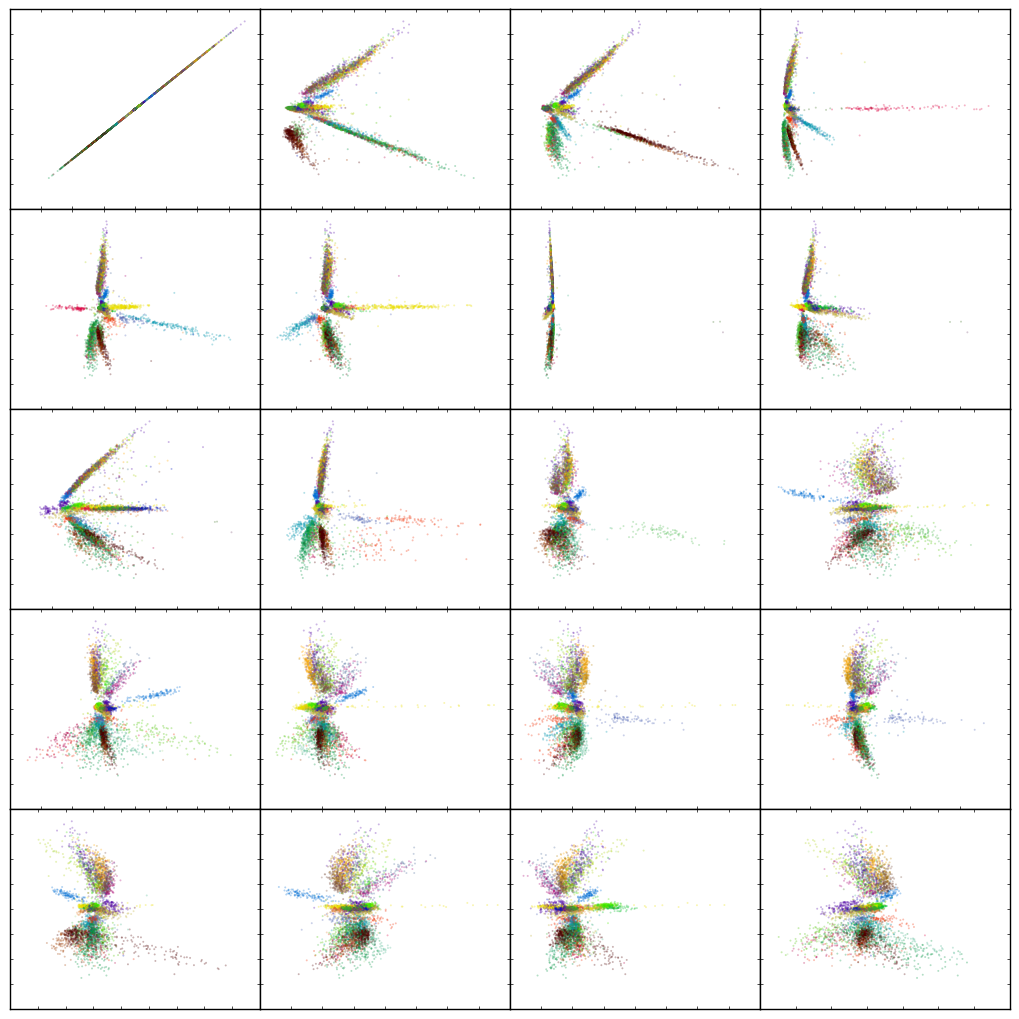

In [25]:
figure( figsize=(10,10))
#couple_pcs = list(combinations(range(6),2))
ccc = 0.3*cm.prism(labels/max(labels)) + 0.7*cm.spectral(labels/max(labels))
for i, a in enumerate(range(20)):
    ax = subplot(5,4,i+1)
    scatter(  fcs[i,:],fcs[0,:],s=2, c=ccc, lw=0, alpha=0.3)
    ax.tick_params(labelbottom=False, labeltop=False, labelleft=False, labelright=False, size=2)
    
tight_layout(pad=0.01, h_pad=0.01, w_pad=0.01)

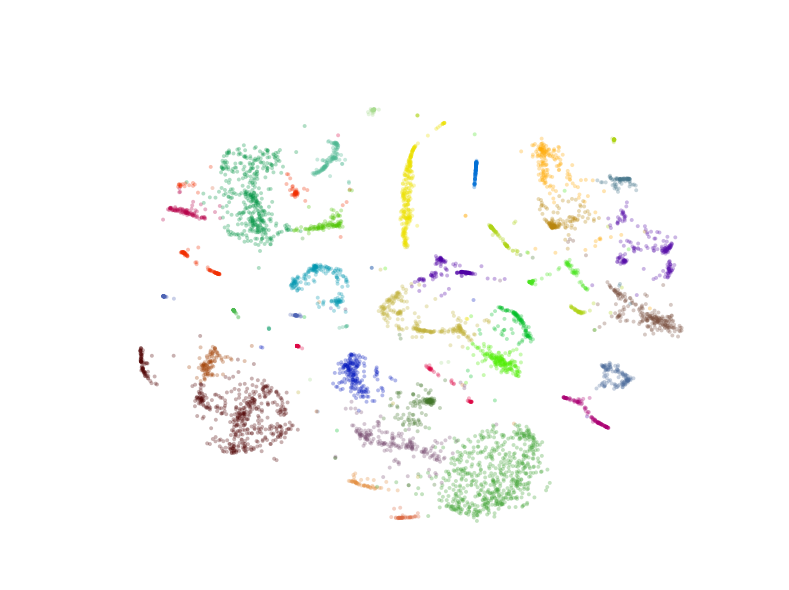

In [28]:
tsne_pos = TSNE(init=fcs.T[:, :2], perplexity=80, learning_rate=800, early_exaggeration=8.).fit_transform(fcs.T)
figure(figsize=(8,6))
scatter(tsne_pos[:,0],tsne_pos[:,1], alpha=0.3, s=8, lw=0, c=ccc)
axis("off")
tight_layout()

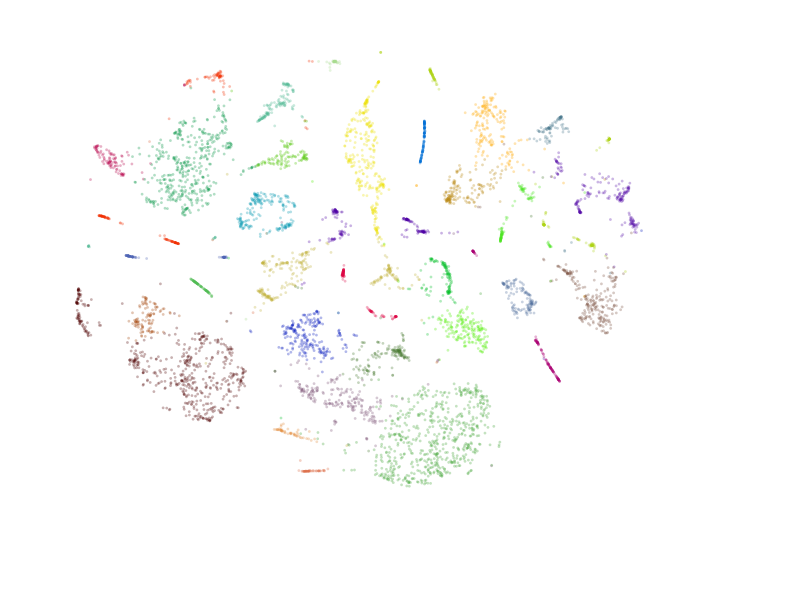

In [29]:
figure(figsize=(8,6))
scatter(tsne_pos[:,0],tsne_pos[:,1], alpha=0.3, s=4, lw=0, c=ccc)
axis("off")
tight_layout()

In [29]:
from typing import *

In [54]:
from math import exp, lgamma, log
from scipy.special import beta, betainc, betaln

def p_half(k: int, n: int, f: float) -> float:
	"""
	Return probability that at least half the cells express, if we have observed k of n cells expressing

	Args:
		k (int):	Number of observed positive cells
		n (int):	Total number of cells

	Remarks:
		Probability that at least half the cells express, when we observe k positives among n cells is:

			p|k,n = 1-(betainc(1+k, 1-k+n, 0.5)*gamma(2+n)/(gamma(1+k)*gamma(1-k+n))/beta(1+k, 1-k+n)

	Note:
		The formula was derived in Mathematica by computing

			Probability[x > f, {x \[Distributed] BetaDistribution[1 + k, 1 + n - k]}]

		and then replacing f by 0.5
	"""

	# These are the prior hyperparameters beta(a,b)
	a = 1.5
	b = 2

	# We really want to calculate this:
	# p = 1-(betainc(a+k, b-k+n, 0.5)*beta(a+k, b-k+n)*gamma(a+b+n)/(gamma(a+k)*gamma(b-k+n)))
	#
	# But it's numerically unstable, so we need to work on log scale (and special-case the incomplete beta)

	incb = betainc(a + k, b - k + n, f)
	if incb == 0:
		p = 1.0
	else:
		p = 1.0 - exp(log(incb) + betaln(a + k, b - k + n) + lgamma(a + b + n) - lgamma(a + k) - lgamma(b - k + n))
	return p

def betabinomial_trinarize_array(array: np.ndarray, labels: np.ndarray, pep: float, f: float, n_labels: int = None) -> Tuple[np.ndarray, np.ndarray]:
    """
    Trinarize a vector, grouped by labels, using a beta binomial model

    Args:
        array (ndarray of ints):	The input vector of ints
        labels (ndarray of ints):	Group labels 0, 1, 2, ....
        pep (float):				The desired posterior error probability (PEP)

    Returns:
        ps (ndarray of float):		The posterior probability of expression in at least a fraction f
        expr_by_label (ndarray of float): The trinarized expression pattern (one per label)

    Remarks:
        We calculate probability p that at least half the cells express (in each group),
        and compare with pep, setting the binary pattern to 1 if p > pep,
        -1 if p < (1 - pep) and 0 otherwise.
    """

    if n_labels is None:
        n_labels = np.max(labels) + 1
    n_by_label = np.bincount(labels, minlength=n_labels)
    k_by_label = np.zeros(n_labels)
    for lbl in range(n_labels):
        if np.sum(labels == lbl) == 0:
            continue
        k_by_label[lbl] = np.count_nonzero(array[np.where(labels == lbl)[0]])

    vfunc = np.vectorize(p_half)
    ps = vfunc(k_by_label, n_by_label, f)

    expr_by_label = np.zeros(n_labels) + 0.5
    expr_by_label[np.where(ps > (1 - pep))[0]] = 1
    expr_by_label[np.where(ps < pep)[0]] = 0

    return (ps, expr_by_label)

def expression_patterns(X: np.ndarray, labels: np.ndarray,
                        pep: float, f: float, cells: np.ndarray = None) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Derive enrichment and trinary scores for all genes

    Args:
        ds (LoomConnection):	Dataset
        labels (numpy array):	Cluster labels (one per cell)
        pep (float):			Desired posterior error probability
        f (float):				Fraction required for a gene to be considered 'expressed'
        cells (nump array):		Indices of cells to include

    Returns:
        enrichment (numpy 2d array):	Array of (n_genes, n_labels)
        trinary (numpy 2d array):		Array of (n_genes, n_labels)

    Remarks:
        If the cells argument is provided, the labels should include only those cells. That is,
        labels.shape[0] == cells.shape[0].

        Amit says,
        regarding marker genes.
        i usually rank the genes by some kind of enrichment score.
        score1 = mean of gene within the cluster / mean of gene in all cells
        score2 = fraction of positive cells within cluster / fraction of positive cells in all cells

        enrichment score = score1 * score2^power   (where power == 0.5 or 1) i usually use 1 for 10x data
    """

    n_labels = np.max(labels) + 1

    enrichment = np.empty((X.shape[0], n_labels))
    trinary_pat = np.empty((X.shape[0], n_labels))
    trinary_prob = np.empty((X.shape[0], n_labels))
    for row in range(X.shape[0]):
        if cells is None:
            data = X[row, :]
        else:
            data = X[row, :][cells]
        mu0 = np.mean(data)
        f0 = np.count_nonzero(data)
        score1 = np.zeros(n_labels)
        score2 = np.zeros(n_labels)
        for lbl in range(n_labels):
            if np.sum(labels == lbl) == 0:
                continue
            selection = data[np.where(labels == lbl)[0]]
            if mu0 == 0 or f0 == 0:
                score1[lbl] = 0
                score2[lbl] = 0
            else:
                score1[lbl] = np.mean(selection) / mu0
                score2[lbl] = np.count_nonzero(selection) / f0
        enrichment[row, :] = score1 * score2
        trinary_prob[row, :], trinary_pat[row, :] = betabinomial_trinarize_array(data, labels, pep, f)
    return (enrichment, trinary_prob, trinary_pat)

(enrichment, trinary_prob, trinary_pat) = expression_patterns(data, labels, pep=0.05, f=0.2, cells=None)

In [245]:
sys.path.append("/home/gioele/Github/Loom/python/loompy/")

In [244]:
import loompy
from imp import reload
from loompy import
loompy = reload(loompy)

In [ ]:
loompy.

In [246]:
import dummy_loompy

TabError: inconsistent use of tabs and spaces in indentation (dummy_loompy.py, line 529)

In [ ]:
aa = cg.AutoAnnotator(ds, root=config["annotation"]["annotation_root"])

In [64]:
pwd

'/home/gioele/BigProject'

In [65]:
cd /home/gioele/Github/

/home/gioele/Github


In [67]:
!git clone https://github.com/linnarsson-lab/auto-annotation.git

Cloning into 'auto-annotation'...
Username for 'https://github.com': ^C


In [ ]:
aa = cg.AutoAnnotator(ds, root="")

In [ ]:
# Auto-annotation
def annotate(self, ds, trinaries):
    """
    Annotate the dataset based on trinarized gene expression
    """
    annotations = np.empty((len(self.tags), trinaries.shape[1]))
    for ix, tag in enumerate(self.tags):
        for cluster in range(trinaries.shape[1]):
            p = 1
            for pos in tag.positives:
                index = np.where(ds.ra.Gene == pos)[0][0]
                p = p*trinaries[index, cluster]
            for neg in tag.negatives:
                index = np.where(ds.ra.Gene == neg)[0][0]
                p = p*(1-trinaries[index, cluster])
            annotations[ix, cluster] = p
    return (self.tags, annotations)

logging.info("Auto-annotating cell types and states")

(tags, annotations) = aa.annotate(ds, trinary_prob)
sizes = np.bincount(labels_all + 1)
save_auto_annotation(build_dir, tissue, sizes, annotations, tags)

In [129]:
def gini_impurity(data: np.ndarray, labels: np.ndarray, kind: str="both"):
    """Efficient implementation to calculate Gini impurity for every threshold in the data range
    This calculates only yhr Right Gini impurity index
    This is a metric used in decision trees (less is better).

    Args 
    ____
        data: np.array1d(dtype=float|int)
            the data vector
        labels np.array1d(dtype=int)
            the labels vector
        kinds: "left", "right", "both"; default "both"
    Returns
    _______
        ginis: np.ndarray shape=(len(thresholds)) 
            Gini indexes
        thresholds: np.ndarray shape (~len(np.unique(data)))
            might be truncated and not go over all np.unique(data)

    """

    bins, ix_uniq, counts = np.unique(data, return_counts=True, return_inverse=True)
    ginis = np.zeros(bins.size-1)
    for i in range(1,bins.size):
        n = bins[i] # the value of the threshold
        # index_of_n = np.where( bins==n )[0][0] # the index of value of the threshold after ranking
        index_of_n = find_first(n,bins)
        
        if kind == "both" and i != 0:
            selec_r = labels[ix_uniq >= index_of_n ]
            selec_l = labels[ix_uniq < index_of_n ]
        elif kind =="left":
            selec = labels[ix_uniq < index_of_n ]
        elif kind == "right":
            selec = labels[ix_uniq >= index_of_n ]
        else:
            selec = labels[ix_uniq >= index_of_n ]
        
        if kind == "both" and i != 0:
            sum_sq_contks_l = np.sum(np.bincount(selec_l)**2)
            sq_N_l = len(selec_l)**2
            gini_l = 1 - (sum_sq_contks_l / sq_N_l)
            
            sum_sq_contks_r = np.sum(np.bincount(selec_r)**2)
            sq_N_r = len(selec_r)**2
            gini_r = 1 - (sum_sq_contks_r / sq_N_r)
            ginis[i-1] = gini_l + gini_r
        else:
            sum_sq_contks = np.sum(np.bincount(selec)**2)
            sq_N = len(selec)**2
            ginis[i-1] = 1 - (sum_sq_contks / sq_N)
    return ginis, bins[1:]

In [ ]:
import 

In [ ]:
np.random

In [ ]:




# Auto-annotation
logging.info("Auto-annotating cell types and states")
aa = cg.AutoAnnotator(ds, root=config["annotation"]["annotation_root"])
(tags, annotations) = aa.annotate(ds, trinary_prob)
sizes = np.bincount(labels_all + 1)
save_auto_annotation(build_dir, tissue, sizes, annotations, tags)

logging.info("Plotting clusters on graph")
plot_clusters(mknn, labels, tsne_pos, tags, annotations, title=tissue, plt_labels=True, outfile=os.path.join(build_dir, tissue + "_tSNE"))

logging.info("Saving attributes")
ds.set_attr("_tSNE_X", tsne_all[:, 0], axis=1)
ds.set_attr("_tSNE_Y", tsne_all[:, 1], axis=1)
ds.set_attr("Clusters", labels_all, axis=1)
ds.set_edges("MKNN", cells[mknn.row], cells[mknn.col], mknn.data, axis=1)
ds.set_edges("KNN", cells[knn.row], cells[knn.col], knn.data, axis=1)
logging.info("Done.")